In [1]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import urllib3
import warnings
import random
from sklearn.metrics import f1_score
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from skimage.io import imread
import tifffile

In [2]:
# Ignore warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=urllib3.exceptions.InsecureRequestWarning)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cpu


In [4]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [5]:
# # Define the directory path
# directory = '/kaggle/input/dataset/UOS2/Images10b/'
# # mask = f'/kaggle/input/dataset/UOS2/Labels/{}'

# # List all files in the directory
# files = []
# for dirname, _, filenames in os.walk(directory):
#     for filename in filenames:
#         files.append(os.path.join(dirname, filename))
        
# # List all files in the directory
# labels = []
# for dirname, _, filenames in os.walk('/kaggle/input/dataset/UOS2/Labels'):
#     for filename in filenames:
#         labels.append(os.path.join(dirname, filename))

# Create image reader

In [6]:
# def Read_images_and_takeRGBband(image_path):
#     random_file = tifffile.imread(image_path)
#     # Select three bands for RGB composite (adjust band indices as needed)
#     red_band_index = 3
#     green_band_index = 2
#     blue_band_index = 1

#     # Normalize bands to 0-255 scale
#     def normalize_band(band):
#         return (band - np.min(band)) / (np.max(band) - np.min(band)) * 255

#     red_band = normalize_band(random_file[:,:,red_band_index])
#     green_band = normalize_band(random_file[:,:,green_band_index])
#     blue_band = normalize_band(random_file[:,:,blue_band_index])

#     # Create RGB composite image
#     rgb_image = np.dstack((red_band, green_band, blue_band)).astype(np.uint8)
#     return rgb_image

In [7]:
# def create_binary_classes(mask):
#     mask_copy = cv2.imread(mask)
#     Fruits = np.array([0, 0, 255])  
#     Vineyald = np.array([255, 0, 127])  
#     non_croped = np.array([0, 0, 0])
#     croped = np.array([0,255,0])

#     # Convert class labels to binary masks for each channel
#     class1_mask = np.all(mask_copy == Fruits, axis=-1)
#     class2_mask = np.all(mask_copy == Vineyald, axis=-1)
#     # non_croped = np.array([0,0,0])

#     # Combine the masks
#     combined_mask = np.logical_or(class1_mask, class2_mask)
#     mask_copy[~combined_mask] = non_croped
#     mask_copy[~np.all(mask_copy==non_croped, axis =-1)] = croped
    
#     return mask_copy

## save the preprocessed data

In [8]:
# import os
# import cv2
# import shutil

# # Create directories for images and labels
# images_output_directory = '/kaggle/working/dataset/images'
# labels_output_directory = '/kaggle/working/dataset/labels'
# os.makedirs(images_output_directory, exist_ok=True)
# os.makedirs(labels_output_directory, exist_ok=True)

# # Save images
# for image_path in files:
#     img = Read_images_and_takeRGBband(image_path)
#     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     image_name = os.path.basename(image_path)
#     output_path = os.path.join(images_output_directory, image_name)
#     cv2.imwrite(output_path, img_rgb)

# # Save labels
# for mask_path in labels:
#     img = create_binary_classes(mask_path)
#     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     image_name = os.path.basename(mask_path)
#     output_path = os.path.join(labels_output_directory, image_name)
#     cv2.imwrite(output_path, img_rgb)

# # Check if all images are processed
# if len(os.listdir(images_output_directory)) == len(files):
#     print('All images are processed')
# else:
#     raise Exception('Some files are not processed')

# # Create a zip folder
# shutil.make_archive('/kaggle/working/dataset', 'zip', '/kaggle/working/dataset')

# Test the functions

In [9]:
# Define the directory path
directory = '/kaggle/input/final-splitted-dataset/test/images'
# mask = f'/kaggle/input/dataset/UOS2/Labels/{}'

# List all files in the directory
files = []
for dirname, _, filenames in os.walk(directory):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
        
# List all files in the directory
labels = []
for dirname, _, filenames in os.walk('/kaggle/input/final-splitted-dataset/test/masks'):
    for filename in filenames:
        labels.append(os.path.join(dirname, filename))

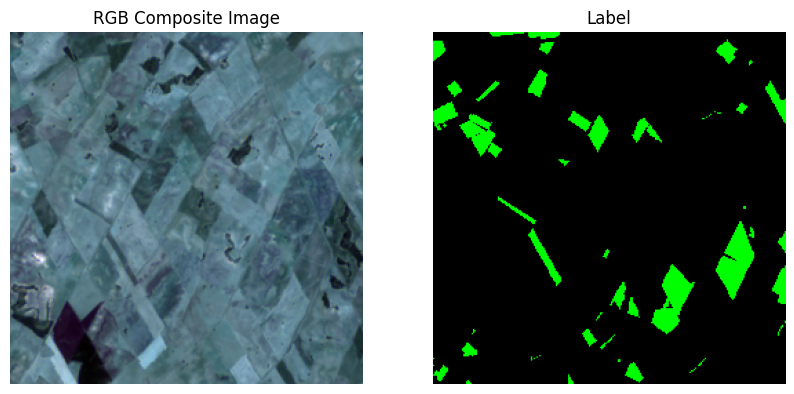

In [ ]:
# Select a random file
random_file_ = np.random.randint(0, len(files)+1)
# print(random_file)
image_path = files[random_file_]


# Display the RGB image
image = cv2.imread(image_path)
mask_copy = cv2.imread(labels[random_file_])

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 6))
axes[0].imshow(image)
axes[0].set_title('RGB Composite Image')
axes[0].axis('off')

axes[1].imshow(mask_copy)
axes[1].set_title('Label')

plt.axis(False)
plt.show()


In [ ]:
# sample_image = np.unique(mask_copy)
# print(sample_image)

# print(image.shape)

In [12]:
# Initialize an empty set to store unique class labels
unique_classes = set()
annotations_dir = "/kaggle/input/final-splitted-dataset/test/masks"
# Iterate through each annotation or label file in the directory
for filename in os.listdir(annotations_dir):
    if filename.endswith(".tif") or filename.endswith(".jpg"):  # Adjust file extensions as needed
        # Load the annotation or label image
        annotation = np.array(Image.open(os.path.join(annotations_dir, filename)))
        # Extract unique class labels and add to the set
        unique_classes.update(np.unique(annotation))

# Total number of classes
num_classes = len(unique_classes)
print("Actual number of classes in the dataset:", unique_classes)

Actual number of classes in the dataset: {0, 255}


In [13]:
from sklearn.model_selection import train_test_split

dataframe = pd.DataFrame({'Images':files, 'Labels':labels})

#Split the data into training, test and validation
data_train, data_test = train_test_split(dataframe, test_size=0.2, random_state=42)
val_train, val_test = train_test_split(data_train, test_size=0.1, random_state=42)

# val_train

In [14]:
# import os
# from PIL import Image
# from torch.utils.data import Dataset
# import numpy as np

# class CarvanaDataset(Dataset):
#     def __init__(self, data, transform=None):
#         self.mask = data['Labels'].values.flatten()
#         self.transform = transform
#         self.images = data['Images'].values.flatten()

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, index):
#         img_path =  self.images[index]
#         mask_path = self.mask[index]
#         image = np.array(Image.open(img_path).convert("RGB"))
#         mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
       
        
#         if self.transform is not None:
#             augmentations = self.transform(image=image, mask=mask)
#             image = augmentations["image"]
#             mask = augmentations["mask"]
#         return image, mask
    
# # train = CarvanaDataset(val_train)
# # u = 0
# # for i, y in train:
# #     while u<10:
# #         print(np.unique(y))
# #         u+=1
    
# #     break

## test 2, carvan dataset

In [15]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import torch
from torchvision import transforms

class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace(".jpg", "_mask.gif"))  # Assuming mask files end with "_mask.gif"
        
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)

        # Normalize mask values to [0, 1] since the model output will be in this range
        mask /= 255.0
        
        if self.transform is not None:
            # Apply transformations
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        
        # Convert to PyTorch tensor
        image = torch.as_tensor(image, dtype=torch.float32)  # Ensure the image is float32 tensor
        mask = torch.as_tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add a channel dimension
        
        return image, mask

# Example usage:
# dataset = CarvanaDataset(image_dir="path/to/images", mask_dir="path/to/masks", transform=your_transform)
# image, mask = dataset[0]


# create dataloaders

# CNN architecture

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import ReduceLROnPlateau

class ConvNN(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.2):
        super(ConvNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate),  # Dropout layer for regularization
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate),  # Dropout layer for regularization
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512], dropout_rate=0.2,
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout_rate = dropout_rate

        # Down part of UNET
        for feature in features:
            self.downs.append(ConvNN(in_channels, feature, self.dropout_rate))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(ConvNN(feature*2, feature, self.dropout_rate))

        self.bottleneck = ConvNN(features[-1], features[-1]*2, self.dropout_rate)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        
        # Apply sigmoid activation to the final layer
        x = torch.sigmoid(self.final_conv(x))
        # Convert probabilities to binary mask using a threshold of 0.5
        x = (x > 0.5).float()
        
        return x

def test():
    x = torch.randn((3, 3, 256, 256))
    model = UNET(in_channels=3, out_channels=1)
    preds = model(x)
    print("mask_pred unique:", preds.unique())

if __name__ == "__main__":
    test()


mask_pred unique: tensor([0., 1.])


# count number of trainable parameters

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Call this function after initializing your model to get the count of trainable parameters
model = UNET(in_channels=1, out_channels=2)
print("Number of trainable parameters:", count_parameters(model))

Number of trainable parameters: 31036546


# utility functions

## train model

In [18]:
import torch.optim as optim
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

# Hyperparameters etc.
LEARNING_RATE = 0.001
BATCH_SIZE = 12
NUM_EPOCHS = 5
NUM_CLASSES = 1
NUM_WORKERS = 0
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
LOAD_MODEL = False
TRAIN_IMG_DIR = "/kaggle/input/final-splitted-dataset/train/images"
TRAIN_MASK_DIR = "/kaggle/input/final-splitted-dataset/train/masks"
VAL_IMG_DIR =  "/kaggle/input/final-splitted-dataset/val/images"
VAL_MASK_DIR = "/kaggle/input/final-splitted-dataset/val/masks"
TEST_IMG_DIR = "/kaggle/input/final-splitted-dataset/test/images"
TEST_MASK_DIR =  "/kaggle/input/final-splitted-dataset/test/masks"

In [19]:
from sklearn.metrics import f1_score

def train_fn(train_loader, model, optimizer, loss_fn, scaler):
    model.train()
    train_loss = 0.0
    for images, targets in train_loader:
        images = images.to(device)
        #targets = targets.long().to(device)
        targets = targets.float().unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = loss_fn(outputs, targets)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item() * images.size(0)  # Accumulate the loss
        
    train_loss /= len(train_loader.dataset)  # Calculate the average loss
    return train_loss

def val_fn(val_loader, model, loss_fn):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)
            #targets = targets.long().to(device)
            targets = targets.float().unsqueeze(1).to(device)


            outputs = model(images)
            loss = loss_fn(outputs, targets)

            val_loss += loss.item() * images.size(0)  # Accumulate the loss

    val_loss /= len(val_loader.dataset)  # Calculate the average loss
    return val_loss

def check_f1_score(loader, model, device=device):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            preds = torch.argmax(model(x), dim=1)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(y.cpu().numpy().flatten())
    f1 = f1_score(all_labels, all_preds, average='macro')
    model.train()
    return f1

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    
import os
import shutil

def save_predictions_as_imgs(loader, model, folder="/kaggle/working/predictions"):
    os.makedirs(folder, exist_ok=True)
    model.eval()
    class_names = ["crop", "non-crop"]
    for idx, (x, y) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            preds = torch.argmax(torch.softmax(model(x), dim=1), dim=1)  # Get predicted classes
        for i in range(preds.shape[0]):
            pred_img = preds[i].cpu().numpy()
            true_img = y[i].cpu().numpy()
            # Determine class folder
            class_folder = os.path.join(folder, class_names[true_img])
            os.makedirs(class_folder, exist_ok=True)
            # Save images
            pred_path = os.path.join(class_folder, f"predicted_{idx}_{i}.png")
            true_path = os.path.join(class_folder, f"ground_truth_{idx}_{i}.png")
            # Save predicted image
            plt.imsave(pred_path, pred_img, cmap='gray')
            # Save ground truth image
            plt.imsave(true_path, true_img, cmap='gray')
    model.train()

In [20]:
NUM_CLASSES

1

In [21]:
# train_ds = CarvanaDataset(image_dir=TRAIN_IMG_DIR, mask_dir=train_maskdir, transform=train_transform)

# function getloaders

In [22]:
def get_loaders(train_dir, train_maskdir, val_dir, val_maskdir, test_dir, test_maskdir, batch_size, train_transform, val_transform, test_transform, num_workers=4):
    train_ds = CarvanaDataset(image_dir=train_dir, mask_dir=train_maskdir, transform=train_transform)
    val_ds = CarvanaDataset(image_dir=val_dir, mask_dir=val_maskdir, transform=val_transform)
    test_ds = CarvanaDataset(image_dir=test_dir, mask_dir=test_maskdir, transform=test_transform)
    train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers,shuffle=False)
    return train_loader, val_loader, test_loader

In [23]:
# def main():
#     train_transform = A.Compose([
#         A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
#         A.Rotate(limit=35, p=1.0),
#         A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.1),
#         A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
#         ToTensorV2(),
#     ])
#     val_transforms = A.Compose([
#         A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
#         A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
#         ToTensorV2(),
#     ])
#     test_transforms = A.Compose([
#         A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
#         A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
#         ToTensorV2(),
#     ])

#     train_loader, val_loader, test_loader = get_loaders(
#         TRAIN_IMG_DIR, TRAIN_MASK_DIR, VAL_IMG_DIR, VAL_MASK_DIR, TEST_IMG_DIR, TEST_MASK_DIR,
#         BATCH_SIZE, train_transform, val_transforms, test_transforms, NUM_WORKERS
#     )
    
#     model = UNET(in_channels=3, out_channels=NUM_CLASSES).to(device)
#     loss_fn = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#     if LOAD_MODEL:
#         load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)
#     scaler = torch.cuda.amp.GradScaler()

#     train_losses = []
#     train_accuracies = []
#     val_losses = []
#     val_accuracies = []

#     for epoch in range(NUM_EPOCHS):
#         train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)
#         train_losses.append(train_loss)
        
#         train_accuracy = check_f1_score(train_loader, model)
#         train_accuracies.append(train_accuracy)
        
#         val_loss = val_fn(val_loader, model, loss_fn)
#         val_losses.append(val_loss)
        
#         val_accuracy = check_f1_score(val_loader, model)
#         val_accuracies.append(val_accuracy)
        
#         print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        
#         checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
#         save_checkpoint(checkpoint)

#     test_accuracy = check_f1_score(test_loader, model)
#     print(f"Test Accuracy: {test_accuracy:.2f}%")

#     # Optionally, you can plot the training and validation metrics
#     import matplotlib.pyplot as plt
#     plt.plot(train_losses, label='Train Loss')
#     plt.plot(val_losses, label='Validation Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.show()

#     plt.plot(train_accuracies, label='Train Accuracy')
#     plt.plot(val_accuracies, label='Validation Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.show()

# if __name__ == "__main__":
#     main()


In [24]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Additional augmentation techniques
additional_train_transform = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.RandomCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, p=0.5),
    A.GaussianBlur(p=0.1),
    A.ElasticTransform(p=0.1),
])

# Update the existing train_transform
train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Rotate(limit=35, p=0.5),  # Reduce rotation limit
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(max_pixel_value=255.0),
    additional_train_transform,  # Add the additional augmentation techniques
    ToTensorV2(),
])

# Define validation and test transformations (keep them the same)
val_transforms = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(max_pixel_value=255.0),
    ToTensorV2(),
])

test_transforms = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(max_pixel_value=255.0),
    ToTensorV2(),
])

# Reinitialize data loaders with updated transformations
train_loader, val_loader, test_loader = get_loaders(
    TRAIN_IMG_DIR, TRAIN_MASK_DIR, VAL_IMG_DIR, VAL_MASK_DIR, TEST_IMG_DIR, TEST_MASK_DIR,
    BATCH_SIZE, train_transform, val_transforms, test_transforms, NUM_WORKERS
)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms.functional as TF

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=5, save_path="best_model.pth"):
    # Check if the saved model exists and load it
    if os.path.exists(save_path):
        model.load_state_dict(torch.load(save_path))
        print("Model loaded from checkpoint.")

    best_val_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.float())  # Ensure inputs are float32 tensors
            
            # Ensure labels require gradients
            labels.requires_grad = True
            
            # Calculate the loss
            loss = criterion(outputs, labels)
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            
            # Track the training loss
            running_loss += loss.item() * inputs.size(0)
            
            # Convert outputs to binary predictions for accuracy calculation
            predicted = outputs.round()  # Round to get binary predictions
            correct_train += (predicted == labels).sum().item()  # Count correct predictions
            total_train += labels.numel()  # Total number of labels
        
        # Calculate training accuracy and loss
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs.float())  # Ensure inputs are float32 tensors
                
                # Calculate the loss
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                
                # Convert outputs to binary predictions for accuracy calculation
                predicted = outputs.round()  # Round to get binary predictions
                correct_val += (predicted == labels).sum().item()  # Count correct predictions
                total_val += labels.numel()  # Total number of labels
            
        # Calculate validation accuracy and loss
        val_loss = running_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct_val / total_val

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Save the model if validation accuracy improved
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            print("Model saved with accuracy {:.2f}%".format(val_accuracy))
        
        # Update the learning rate
        scheduler.step(val_loss)

# Example usage:
# Training parameters
LEARNING_RATE = 0.001
NUM_EPOCHS = 20

# Create model, loss function, optimizer, and scheduler
model = UNET(in_channels=3, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, save_path="best_model.pth")

Epoch 1/20, Train Loss: 1.0206, Train Accuracy: 42.89%, Val Loss: 1.0831, Val Accuracy: 33.45%
Model saved with accuracy 33.45%
Epoch 2/20, Train Loss: 1.0253, Train Accuracy: 42.14%, Val Loss: 1.0671, Val Accuracy: 36.02%
Model saved with accuracy 36.02%
Epoch 3/20, Train Loss: 1.0245, Train Accuracy: 42.30%, Val Loss: 1.0650, Val Accuracy: 36.37%
Model saved with accuracy 36.37%
Epoch 4/20, Train Loss: 1.0261, Train Accuracy: 42.01%, Val Loss: 1.0541, Val Accuracy: 38.11%
Model saved with accuracy 38.11%


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
from PIL import Image

def predict_mask(model, image):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients
        # Resize and convert image to tensor
        image = transforms.ToTensor()(transforms.Resize((256, 256))(image))
        mask_pred = model(image.unsqueeze(0))  # Add batch dimension and predict the mask
    return mask_pred.squeeze().cpu().numpy()

def visualize(image, mask=None, mask_pred=None):
    # Convert image to numpy array
    image = np.array(image)
    
    # Plot image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    
    # Plot ground truth mask if available
    if mask is not None:
        mask = np.array(mask)
        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title('Ground Truth Mask')
    
    # Plot predicted mask if available
    if mask_pred is not None:
        mask_pred = np.array(mask_pred)
        mask_pred = mask_pred.squeeze()  # Remove single-dimensional entries from the shape of an array
        plt.subplot(1, 3, 3)
        plt.imshow(mask_pred, vmin=0, vmax=1)  # Use vmin and vmax to set the color range
        plt.title('Predicted Mask')

    plt.show()

def main():
    # Load your trained model
    model = UNET(in_channels=3, out_channels=1)  # Assuming the output has only one channel
    model.load_state_dict(torch.load("/kaggle/working/best_model.pth", map_location=torch.device('cpu'))) # Load the model
    
    # Load images from the Images directory
    image_files = glob.glob("/kaggle/input/final-splitted-dataset/test/images/**/*.tif", recursive=True)

    # Choose 10 random images
    random_images = random.sample(image_files, 10)

    # Iterate over random images
    for image_file in random_images:
        # Load the image
        image = Image.open(image_file).convert("RGB")
        
        # Load the corresponding mask
        mask_file = image_file.replace("/images/", "/masks/").replace(".tif", ".tif")
        mask = Image.open(mask_file).convert("L")

        # Predict mask
        mask_pred_raw = predict_mask(model, image)

        # Print the predicted mask before thresholding
        print("Raw Predicted Mask shape:", mask_pred_raw.shape)
        print("Raw predicted mask unique:", np.unique(mask_pred_raw))

        # Visualize image, mask, and predicted mask
        visualize(image, mask, mask_pred_raw)


if __name__ == "__main__":
    main()

## predict

In [ ]:
# # Iterate over train_loader
# for batch_idx, (data, targets) in enumerate(train_loader):
#     # Print the shape of the data and targets
#     print(f"Batch {batch_idx}:")
#     print("Data shape:", data.shape)
#     print("Targets shape:", targets.shape)
    
#     # If you want to see a sample from the batch
#     sample_data = data[0]  # Assuming you want to see the first sample
#     sample_target = targets[0]
    
#     # If data is in tensor format, you might want to convert it to numpy for visualization
#     sample_data_np = sample_data.numpy()  # Convert data to numpy array if it's a tensor
#     sample_target_np = sample_target.item()  # Convert target to a Python scalar if it's a tensor
    
#     # Print or visualize the sample data and target label
#     print("Sample data (first sample):", sample_data_np)
#     print("Sample target (first sample):", sample_target_np)
#     break  # Break after printing the first batch for brevity

In [ ]:
# Img2 = cv2.imread("/kaggle/working/predictions/sample_84_image_0.png")
# plt.imshow(Img2)/